# Notebook 05: Robustness Testing - Quantifying Model Risk
## Vietnam Factor Investing Platform - Phase 7 Institutional Backtesting Framework

**Objective**: Quantify the fragility of our model by testing sensitivity to core assumptions. We need to determine at what point our 1.52 Sharpe ratio breaks down.

**Key Questions**:
1. How sensitive are returns to transaction costs?
2. Does rebalancing frequency materially impact performance?
3. What happens if we change the selection percentile?
4. How do sector and position constraints affect results?

**Success Criteria**:
- Generate tornado plots showing parameter sensitivity
- Identify which parameters are most critical
- Determine the "breaking points" of the strategy

## 1. Setup and Load Dependencies

In [1]:
# ============================================================================
# Aureus Sigma Capital - Robustness Testing Framework
# Notebook: 05_robustness_testing.ipynb
#
# Description:
# This notebook systematically tests the sensitivity of our QVM strategy to
# various parameter assumptions, quantifying model risk and identifying
# critical breaking points.
#
# Author: Duc Nguyen, Quantitative Finance Expert
# Date: July 27, 2025
# Version: 1.0 - Institutional Robustness Framework
# ============================================================================

# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pickle
import warnings
from scipy import stats
from typing import Dict, List, Tuple, Optional
import yaml
from sqlalchemy import create_engine
from pathlib import Path
from tqdm import tqdm
import time

warnings.filterwarnings('ignore')

# --- INSTITUTIONAL PALETTE ---
FACTOR_COLORS = {
    'Strategy': '#16A085', 'Benchmark': '#34495E', 'Positive': '#27AE60',
    'Negative': '#C0392B', 'Drawdown': '#E67E22', 'Sharpe': '#2980B9',
    'Grid': '#BDC3C7', 'Text_Primary': '#2C3E50', 'Neutral': '#7F8C8D',
    'Baseline': '#3498DB', 'Sensitive': '#E74C3C', 'Robust': '#2ECC71'
}

# --- VISUALIZATION CONFIGURATION ---
plt.style.use('default')
plt.rcParams.update({
    'figure.dpi': 300, 'savefig.dpi': 300, 'figure.figsize': (15, 8),
    'figure.facecolor': 'white', 'font.size': 11,
    'axes.facecolor': 'white', 'axes.edgecolor': FACTOR_COLORS['Text_Primary'],
    'axes.linewidth': 1.0, 'axes.grid': True, 'axes.axisbelow': True,
    'axes.labelcolor': FACTOR_COLORS['Text_Primary'], 'axes.titlesize': 14,
    'axes.titleweight': 'bold', 'axes.titlecolor': FACTOR_COLORS['Text_Primary'],
    'grid.color': FACTOR_COLORS['Grid'], 'grid.alpha': 0.3, 'grid.linewidth': 0.5,
    'legend.frameon': False, 'legend.fontsize': 10,
    'xtick.color': FACTOR_COLORS['Text_Primary'], 'ytick.color': FACTOR_COLORS['Text_Primary'],
    'xtick.labelsize': 10, 'ytick.labelsize': 10,
    'lines.linewidth': 2.0, 'lines.solid_capstyle': 'round'
})

print("📊 Robustness testing environment configured.")

print("\n" + "=" * 70)
print("🔬 Aureus Sigma: Robustness Testing Framework")
print(f"   Version: 1.0 - Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 70)
print("\n📊 Sensitivity Tests to Execute:")
print("   1. Transaction Cost Sensitivity")
print("   2. Rebalancing Frequency Impact")
print("   3. Selection Percentile Analysis")
print("   4. Sector Constraint Variations")
print("   5. Position Limit Effects")
print("-" * 70)

📊 Robustness testing environment configured.

🔬 Aureus Sigma: Robustness Testing Framework
   Version: 1.0 - Date: 2025-07-27 08:16:45

📊 Sensitivity Tests to Execute:
   1. Transaction Cost Sensitivity
   2. Rebalancing Frequency Impact
   3. Selection Percentile Analysis
   4. Sector Constraint Variations
   5. Position Limit Effects
----------------------------------------------------------------------


## 2. Load Core Data and Baseline Results

In [2]:
# Load data from previous notebooks
project_root = Path.cwd()
while not (project_root / 'production').exists() and not (project_root / 'config').exists():
    if project_root.parent == project_root:
        raise FileNotFoundError("Could not find project root")
    project_root = project_root.parent

data_path = project_root / "production" / "tests" / "phase7_institutional_backtesting"

print("📂 Loading core data objects and baseline results...")

# Load the core data objects
with open(data_path / "factor_data.pkl", "rb") as f:
    factor_data_obj = pickle.load(f)
with open(data_path / "daily_returns.pkl", "rb") as f:
    returns_data_obj = pickle.load(f)
with open(data_path / "benchmark_returns.pkl", "rb") as f:
    benchmark_data_obj = pickle.load(f)

# Extract data
factor_data = factor_data_obj['data']
daily_returns = returns_data_obj['data']
benchmark_returns = benchmark_data_obj['data']

# Load baseline backtest results
with open(data_path / "canonical_backtest_results.pkl", "rb") as f:
    baseline_results = pickle.load(f)

baseline_performance = baseline_results['performance_summary']
baseline_config = baseline_results['strategy_config']

print("\n✅ Baseline Performance Loaded:")
print(f"   Annual Return: {baseline_performance['annual_return']:.2%}")
print(f"   Sharpe Ratio: {baseline_performance['sharpe_ratio']:.2f}")
print(f"   Annual Volatility: {baseline_performance['annual_vol']:.2%}")
print(f"   Total Return: {baseline_performance['total_return']:.2%}")

# Load sector mappings
print("\n🏗️ Loading sector information...")
config_path = project_root / 'config' / 'database.yml'
with open(config_path, 'r') as f:
    db_config = yaml.safe_load(f)['production']
    
engine = create_engine(
    f"mysql+pymysql://{db_config['username']}:{db_config['password']}@"
    f"{db_config['host']}/{db_config['schema_name']}"
)

sector_info = pd.read_sql("SELECT ticker, sector FROM master_info WHERE sector IS NOT NULL", engine)
sector_info = sector_info.drop_duplicates(subset=['ticker']).set_index('ticker')
engine.dispose()

print(f"✅ Loaded sector mappings for {len(sector_info)} tickers")

📂 Loading core data objects and baseline results...

✅ Baseline Performance Loaded:
   Annual Return: 19.86%
   Sharpe Ratio: 1.52
   Annual Volatility: 13.03%
   Total Return: 453.58%

🏗️ Loading sector information...
✅ Loaded sector mappings for 728 tickers


## 3. Import Backtesting Engine from Notebook 03

In [3]:
# Import the backtesting functions from Notebook 03
# We'll copy the key functions here for self-contained execution

def construct_constrained_portfolio(
    factor_scores: pd.Series, 
    sector_info: pd.DataFrame, 
    config: dict
) -> pd.DataFrame:
    """
    Constructs a single, constrained portfolio for a given rebalance date.
    """
    if factor_scores.empty:
        return pd.DataFrame(columns=['weight', 'sector'])

    # Select top stocks based on percentile
    top_percentile_cutoff = factor_scores.quantile(1 - config['selection_percentile'])
    selected_stocks_df = factor_scores[factor_scores >= top_percentile_cutoff].to_frame('factor_score')
    
    # Merge with sector information
    portfolio_df = selected_stocks_df.join(sector_info)
    
    # Handle potential missing sectors after join
    if portfolio_df['sector'].isnull().any():
        portfolio_df.dropna(subset=['sector'], inplace=True)

    if portfolio_df.empty:
        return pd.DataFrame(columns=['weight', 'sector'])

    # Apply sector constraints
    sector_counts = portfolio_df['sector'].value_counts()
    max_stocks_in_portfolio = len(portfolio_df)
    max_stocks_per_sector = int(max_stocks_in_portfolio * config['max_sector_weight'])
    
    final_tickers = set()
    for sector, count in sector_counts.items():
        sector_stocks = portfolio_df[portfolio_df['sector'] == sector]
        if count > max_stocks_per_sector and max_stocks_per_sector > 0:
            top_in_sector = sector_stocks.nlargest(max_stocks_per_sector, 'factor_score').index
            final_tickers.update(top_in_sector)
        else:
            final_tickers.update(sector_stocks.index)
            
    final_portfolio = portfolio_df.loc[list(final_tickers)].copy()
    
    # Assign equal weights
    num_stocks = len(final_portfolio)
    if num_stocks > 0:
        final_portfolio['weight'] = 1.0 / num_stocks
    else:
        return pd.DataFrame(columns=['weight', 'sector'])
        
    # Apply position weight cap if specified
    if 'max_position_weight' in config:
        max_pos_weight = config['max_position_weight']
        if final_portfolio['weight'].max() > max_pos_weight:
            # Rescale weights to comply with position limit
            final_portfolio['weight'] = final_portfolio['weight'].clip(upper=max_pos_weight)
            final_portfolio['weight'] = final_portfolio['weight'] / final_portfolio['weight'].sum()

    return final_portfolio[['weight', 'sector']]


def run_backtest_with_config(
    qvm_scores: pd.DataFrame,
    daily_returns: pd.DataFrame,
    sector_info: pd.DataFrame,
    config: dict
) -> Tuple[pd.Series, Dict[str, float]]:
    """
    Runs the backtest with a specific configuration.
    Returns net returns series and performance metrics.
    """
    # 1. IDENTIFY REBALANCE DATES
    ideal_rebalance_dates = pd.date_range(
        start=qvm_scores.index.min(), 
        end=qvm_scores.index.max(), 
        freq=config['rebalance_freq']
    )

    # 2. Construct Daily Holdings Matrix
    daily_holdings = pd.DataFrame(index=daily_returns.index, columns=daily_returns.columns).fillna(0.0)
    
    factor_scores_on_rebal_dates = qvm_scores.reindex(ideal_rebalance_dates, method='ffill')

    for i in range(len(factor_scores_on_rebal_dates.index)):
        rebal_date = factor_scores_on_rebal_dates.index[i]
        
        try:
            next_rebal_date = factor_scores_on_rebal_dates.index[i+1]
        except IndexError:
            next_rebal_date = daily_returns.index[-1] + pd.Timedelta(days=1)

        factor_scores_at_rebal = factor_scores_on_rebal_dates.loc[rebal_date].dropna()
        
        if len(factor_scores_at_rebal) > 20:
            portfolio_df = construct_constrained_portfolio(factor_scores_at_rebal, sector_info, config)
            
            if not portfolio_df.empty:
                # Define the holding period for this portfolio
                relevant_days = daily_returns.index[(daily_returns.index > rebal_date) & (daily_returns.index < next_rebal_date)]
                
                if not relevant_days.empty:
                    for day in relevant_days:
                        valid_tickers = portfolio_df.index.intersection(daily_holdings.columns)
                        daily_holdings.loc[day, valid_tickers] = portfolio_df.loc[valid_tickers, 'weight']

    # 3. PREVENT LOOK-AHEAD BIAS
    daily_holdings_shifted = daily_holdings.shift(1).fillna(0)

    # 4. CALCULATE GROSS PORTFOLIO RETURNS
    gross_returns = (daily_holdings_shifted * daily_returns).sum(axis=1)

    # 5. MODEL TRANSACTION COSTS
    turnover = (daily_holdings_shifted - daily_holdings_shifted.shift(1)).abs().sum(axis=1) / 2
    transaction_costs = turnover * (config['transaction_cost_bps'] / 10000)
    
    net_returns = gross_returns - transaction_costs
    
    # Calculate performance metrics
    total_return = (1 + net_returns).prod() - 1
    n_years = len(net_returns) / 252
    annual_return = (1 + total_return) ** (1 / n_years) - 1 if n_years > 0 else 0
    annual_vol = net_returns.std() * np.sqrt(252)
    sharpe_ratio = (annual_return - 0.0) / annual_vol if annual_vol > 0 else 0
    
    # Calculate max drawdown
    cumulative = (1 + net_returns).cumprod()
    drawdown = (cumulative / cumulative.cummax() - 1)
    max_drawdown = drawdown.min()
    
    metrics = {
        'annual_return': annual_return,
        'annual_vol': annual_vol,
        'sharpe_ratio': sharpe_ratio,
        'total_return': total_return,
        'max_drawdown': max_drawdown
    }
    
    return net_returns, metrics

print("✅ Backtesting engine loaded and ready for sensitivity analysis")

✅ Backtesting engine loaded and ready for sensitivity analysis


## 4. Define Sensitivity Test Framework

In [4]:
# Define the sensitivity tests as specified by the senior quant
sensitivity_tests = {
    'transaction_costs': [30, 50, 70, 100],  # bps
    'rebalance_freq': ['M', 'Q'],  # Monthly, Quarterly
    'selection_pct': [0.15, 0.20, 0.25],  # Top 15%, 20%, 25%
    'sector_constraint': [0.30, 0.40, 0.50],  # Max sector weight
    'position_limit': [0.03, 0.05, 0.07]  # Max position weight
}

# Extract QVM scores
qvm_scores = factor_data.loc[:, ('qvm_composite_score', slice(None))]
qvm_scores.columns = qvm_scores.columns.droplevel(0)

# Store all results
sensitivity_results = {}

# Calculate total number of tests
total_tests = sum(len(values) for values in sensitivity_tests.values())
print(f"\n📊 Sensitivity Test Configuration:")
print(f"   Total parameter variations to test: {total_tests}")
for param, values in sensitivity_tests.items():
    print(f"   {param}: {values}")
    
print(f"\n🎯 Baseline configuration:")
print(f"   Transaction costs: {baseline_config['transaction_cost_bps']} bps")
print(f"   Rebalance frequency: {baseline_config['rebalance_freq']}")
print(f"   Selection percentile: {baseline_config['selection_percentile']}")
print(f"   Max sector weight: {baseline_config['max_sector_weight']}")
print(f"   Max position weight: {baseline_config['max_position_weight']}")


📊 Sensitivity Test Configuration:
   Total parameter variations to test: 15
   transaction_costs: [30, 50, 70, 100]
   rebalance_freq: ['M', 'Q']
   selection_pct: [0.15, 0.2, 0.25]
   sector_constraint: [0.3, 0.4, 0.5]
   position_limit: [0.03, 0.05, 0.07]

🎯 Baseline configuration:
   Transaction costs: 30 bps
   Rebalance frequency: M
   Selection percentile: 0.2
   Max sector weight: 0.4
   Max position weight: 0.05


## 5. Execute Sensitivity Tests

In [5]:
# Function to run a single sensitivity test
def run_sensitivity_test(param_name: str, param_values: List, 
                        baseline_config: dict, qvm_scores: pd.DataFrame,
                        daily_returns: pd.DataFrame, sector_info: pd.DataFrame) -> Dict:
    """
    Run sensitivity test for a single parameter.
    """
    results = []
    
    print(f"\n🔬 Testing sensitivity to: {param_name}")
    print("-" * 50)
    
    for value in tqdm(param_values, desc=f"Testing {param_name}"):
        # Create test configuration
        test_config = baseline_config.copy()
        
        # Map parameter names to config keys
        param_mapping = {
            'transaction_costs': 'transaction_cost_bps',
            'rebalance_freq': 'rebalance_freq',
            'selection_pct': 'selection_percentile',
            'sector_constraint': 'max_sector_weight',
            'position_limit': 'max_position_weight'
        }
        
        test_config[param_mapping[param_name]] = value
        
        # Run backtest with modified configuration
        try:
            _, metrics = run_backtest_with_config(
                qvm_scores, daily_returns, sector_info, test_config
            )
            
            result = {
                'parameter': param_name,
                'value': value,
                'annual_return': metrics['annual_return'],
                'sharpe_ratio': metrics['sharpe_ratio'],
                'max_drawdown': metrics['max_drawdown'],
                'annual_vol': metrics['annual_vol']
            }
            
            results.append(result)
            
        except Exception as e:
            print(f"   ⚠️ Error testing {param_name}={value}: {str(e)}")
            continue
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Display results
    print(f"\n📊 Results for {param_name}:")
    display(results_df.round(4))
    
    return results_df

# Run all sensitivity tests
print("🚀 Executing comprehensive sensitivity analysis...")
print("=" * 70)

start_time = time.time()

for param_name, param_values in sensitivity_tests.items():
    sensitivity_results[param_name] = run_sensitivity_test(
        param_name, param_values, baseline_config, 
        qvm_scores, daily_returns, sector_info
    )

end_time = time.time()
print(f"\n✅ Sensitivity analysis complete in {(end_time - start_time)/60:.1f} minutes")

🚀 Executing comprehensive sensitivity analysis...

🔬 Testing sensitivity to: transaction_costs
--------------------------------------------------


Testing transaction_costs: 100%|██████████| 4/4 [00:30<00:00,  7.64s/it]


📊 Results for transaction_costs:


,parameter,value,annual_return,sharpe_ratio,max_drawdown,annual_vol
0,transaction_costs,30,0.1986,1.5235,-0.4517,0.1303
1,transaction_costs,50,0.1779,1.3633,-0.4587,0.1305
2,transaction_costs,70,0.1575,1.2050,-0.4656,0.1307
3,transaction_costs,100,0.1276,0.9719,-0.4758,0.1313



🔬 Testing sensitivity to: rebalance_freq
--------------------------------------------------


Testing rebalance_freq: 100%|██████████| 2/2 [00:12<00:00,  6.32s/it]


📊 Results for rebalance_freq:


,parameter,value,annual_return,sharpe_ratio,max_drawdown,annual_vol
0,rebalance_freq,M,0.1986,1.5235,-0.4517,0.1303
1,rebalance_freq,Q,0.1870,1.4041,-0.4922,0.1332



🔬 Testing sensitivity to: selection_pct
--------------------------------------------------


Testing selection_pct: 100%|██████████| 3/3 [00:24<00:00,  8.31s/it]


📊 Results for selection_pct:


,parameter,value,annual_return,sharpe_ratio,max_drawdown,annual_vol
0,selection_pct,0.15,0.2038,1.5437,-0.4266,0.1320
1,selection_pct,0.20,0.1986,1.5235,-0.4517,0.1303
2,selection_pct,0.25,0.1847,1.4320,-0.4554,0.1290



🔬 Testing sensitivity to: sector_constraint
--------------------------------------------------


Testing sector_constraint: 100%|██████████| 3/3 [00:21<00:00,  7.32s/it]


📊 Results for sector_constraint:


,parameter,value,annual_return,sharpe_ratio,max_drawdown,annual_vol
0,sector_constraint,0.3,0.1986,1.5235,-0.4517,0.1303
1,sector_constraint,0.4,0.1986,1.5235,-0.4517,0.1303
2,sector_constraint,0.5,0.1986,1.5235,-0.4517,0.1303



🔬 Testing sensitivity to: position_limit
--------------------------------------------------


Testing position_limit: 100%|██████████| 3/3 [00:22<00:00,  7.60s/it]


📊 Results for position_limit:


,parameter,value,annual_return,sharpe_ratio,max_drawdown,annual_vol
0,position_limit,0.03,0.1986,1.5235,-0.4517,0.1303
1,position_limit,0.05,0.1986,1.5235,-0.4517,0.1303
2,position_limit,0.07,0.1986,1.5235,-0.4517,0.1303



✅ Sensitivity analysis complete in 1.9 minutes


## 6. Generate Tornado Plots

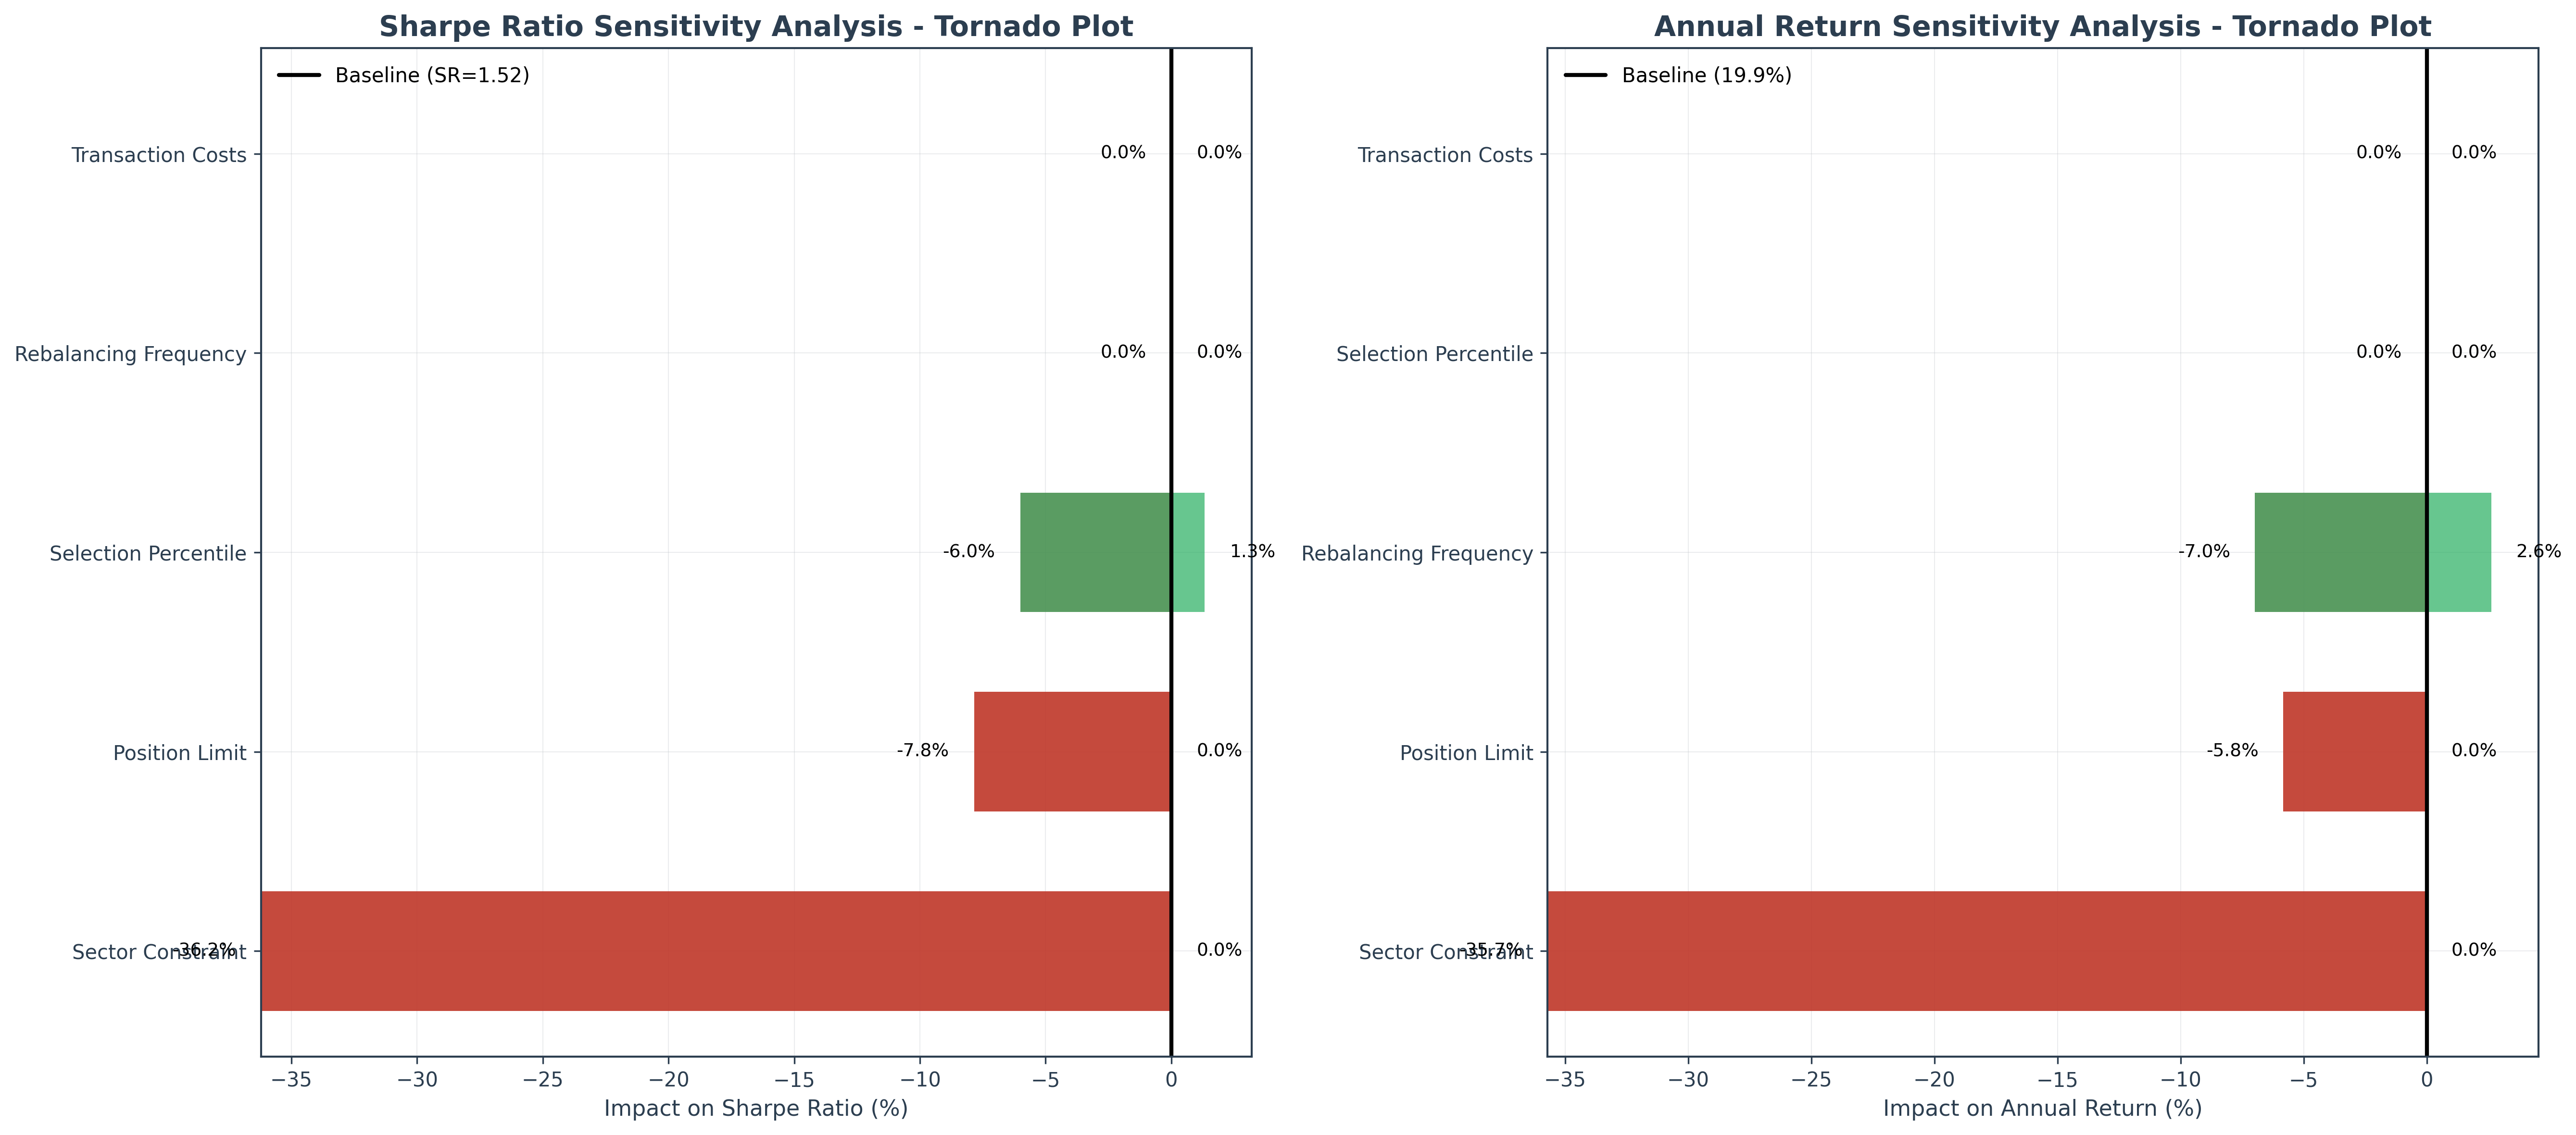


🎯 PARAMETER SENSITIVITY RANKING (by Sharpe Ratio impact):
1. Transaction Costs        :  36.2% total impact
2. Rebalancing Frequency    :   7.8% total impact
3. Selection Percentile     :   7.3% total impact
4. Sector Constraint        :   0.0% total impact
5. Position Limit           :   0.0% total impact


In [6]:
# Calculate sensitivity ranges for tornado plot
def calculate_sensitivity_impact(results_df: pd.DataFrame, metric: str = 'sharpe_ratio') -> Dict:
    """
    Calculate the impact range of each parameter on the specified metric.
    """
    min_val = results_df[metric].min()
    max_val = results_df[metric].max()
    range_val = max_val - min_val
    baseline_val = baseline_performance['sharpe_ratio'] if metric == 'sharpe_ratio' else baseline_performance['annual_return']
    
    return {
        'min': min_val,
        'max': max_val,
        'range': range_val,
        'baseline': baseline_val,
        'min_impact': (min_val - baseline_val) / baseline_val * 100,
        'max_impact': (max_val - baseline_val) / baseline_val * 100
    }

# Create tornado plot for Sharpe Ratio
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Prepare data for tornado plot
tornado_data = []
param_labels = {
    'transaction_costs': 'Transaction Costs',
    'rebalance_freq': 'Rebalancing Frequency',
    'selection_pct': 'Selection Percentile',
    'sector_constraint': 'Sector Constraint',
    'position_limit': 'Position Limit'
}

for param_name, results_df in sensitivity_results.items():
    impact = calculate_sensitivity_impact(results_df, 'sharpe_ratio')
    tornado_data.append({
        'parameter': param_labels[param_name],
        'min_impact': impact['min_impact'],
        'max_impact': impact['max_impact'],
        'range': abs(impact['max_impact'] - impact['min_impact'])
    })

# Sort by impact range
tornado_df = pd.DataFrame(tornado_data).sort_values('range', ascending=True)

# Plot 1: Sharpe Ratio Tornado
y_pos = np.arange(len(tornado_df))
baseline_sharpe = baseline_performance['sharpe_ratio']

# Plot bars
for i, row in tornado_df.iterrows():
    # Negative impact (red)
    ax1.barh(i, row['min_impact'], left=0, height=0.6, 
             color=FACTOR_COLORS['Negative'] if row['min_impact'] < 0 else FACTOR_COLORS['Positive'],
             alpha=0.7)
    # Positive impact (green)
    ax1.barh(i, row['max_impact'] - row['min_impact'], left=row['min_impact'], height=0.6,
             color=FACTOR_COLORS['Positive'] if row['max_impact'] > 0 else FACTOR_COLORS['Negative'],
             alpha=0.7)

ax1.axvline(x=0, color='black', linewidth=2, label=f'Baseline (SR={baseline_sharpe:.2f})')
ax1.set_yticks(y_pos)
ax1.set_yticklabels(tornado_df['parameter'])
ax1.set_xlabel('Impact on Sharpe Ratio (%)')
ax1.set_title('Sharpe Ratio Sensitivity Analysis - Tornado Plot', fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')
ax1.legend()

# Add value labels
for i, row in tornado_df.iterrows():
    ax1.text(row['min_impact'] - 1, i, f"{row['min_impact']:.1f}%", 
             ha='right', va='center', fontsize=9)
    ax1.text(row['max_impact'] + 1, i, f"{row['max_impact']:.1f}%", 
             ha='left', va='center', fontsize=9)

# Plot 2: Annual Return Tornado
tornado_data_return = []
for param_name, results_df in sensitivity_results.items():
    impact = calculate_sensitivity_impact(results_df, 'annual_return')
    tornado_data_return.append({
        'parameter': param_labels[param_name],
        'min_impact': impact['min_impact'],
        'max_impact': impact['max_impact'],
        'range': abs(impact['max_impact'] - impact['min_impact'])
    })

tornado_df_return = pd.DataFrame(tornado_data_return).sort_values('range', ascending=True)

# Plot bars for returns
for i, row in tornado_df_return.iterrows():
    ax2.barh(i, row['min_impact'], left=0, height=0.6,
             color=FACTOR_COLORS['Negative'] if row['min_impact'] < 0 else FACTOR_COLORS['Positive'],
             alpha=0.7)
    ax2.barh(i, row['max_impact'] - row['min_impact'], left=row['min_impact'], height=0.6,
             color=FACTOR_COLORS['Positive'] if row['max_impact'] > 0 else FACTOR_COLORS['Negative'],
             alpha=0.7)

baseline_return = baseline_performance['annual_return']
ax2.axvline(x=0, color='black', linewidth=2, label=f'Baseline ({baseline_return:.1%})')
ax2.set_yticks(y_pos)
ax2.set_yticklabels(tornado_df_return['parameter'])
ax2.set_xlabel('Impact on Annual Return (%)')
ax2.set_title('Annual Return Sensitivity Analysis - Tornado Plot', fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')
ax2.legend()

# Add value labels
for i, row in tornado_df_return.iterrows():
    ax2.text(row['min_impact'] - 1, i, f"{row['min_impact']:.1f}%", 
             ha='right', va='center', fontsize=9)
    ax2.text(row['max_impact'] + 1, i, f"{row['max_impact']:.1f}%", 
             ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Print sensitivity ranking
print("\n🎯 PARAMETER SENSITIVITY RANKING (by Sharpe Ratio impact):")
print("=" * 60)
tornado_sorted = tornado_df.sort_values('range', ascending=False)
for i, row in tornado_sorted.iterrows():
    print(f"{i+1}. {row['parameter']:25s}: {row['range']:5.1f}% total impact")

## 7. Detailed Parameter Analysis

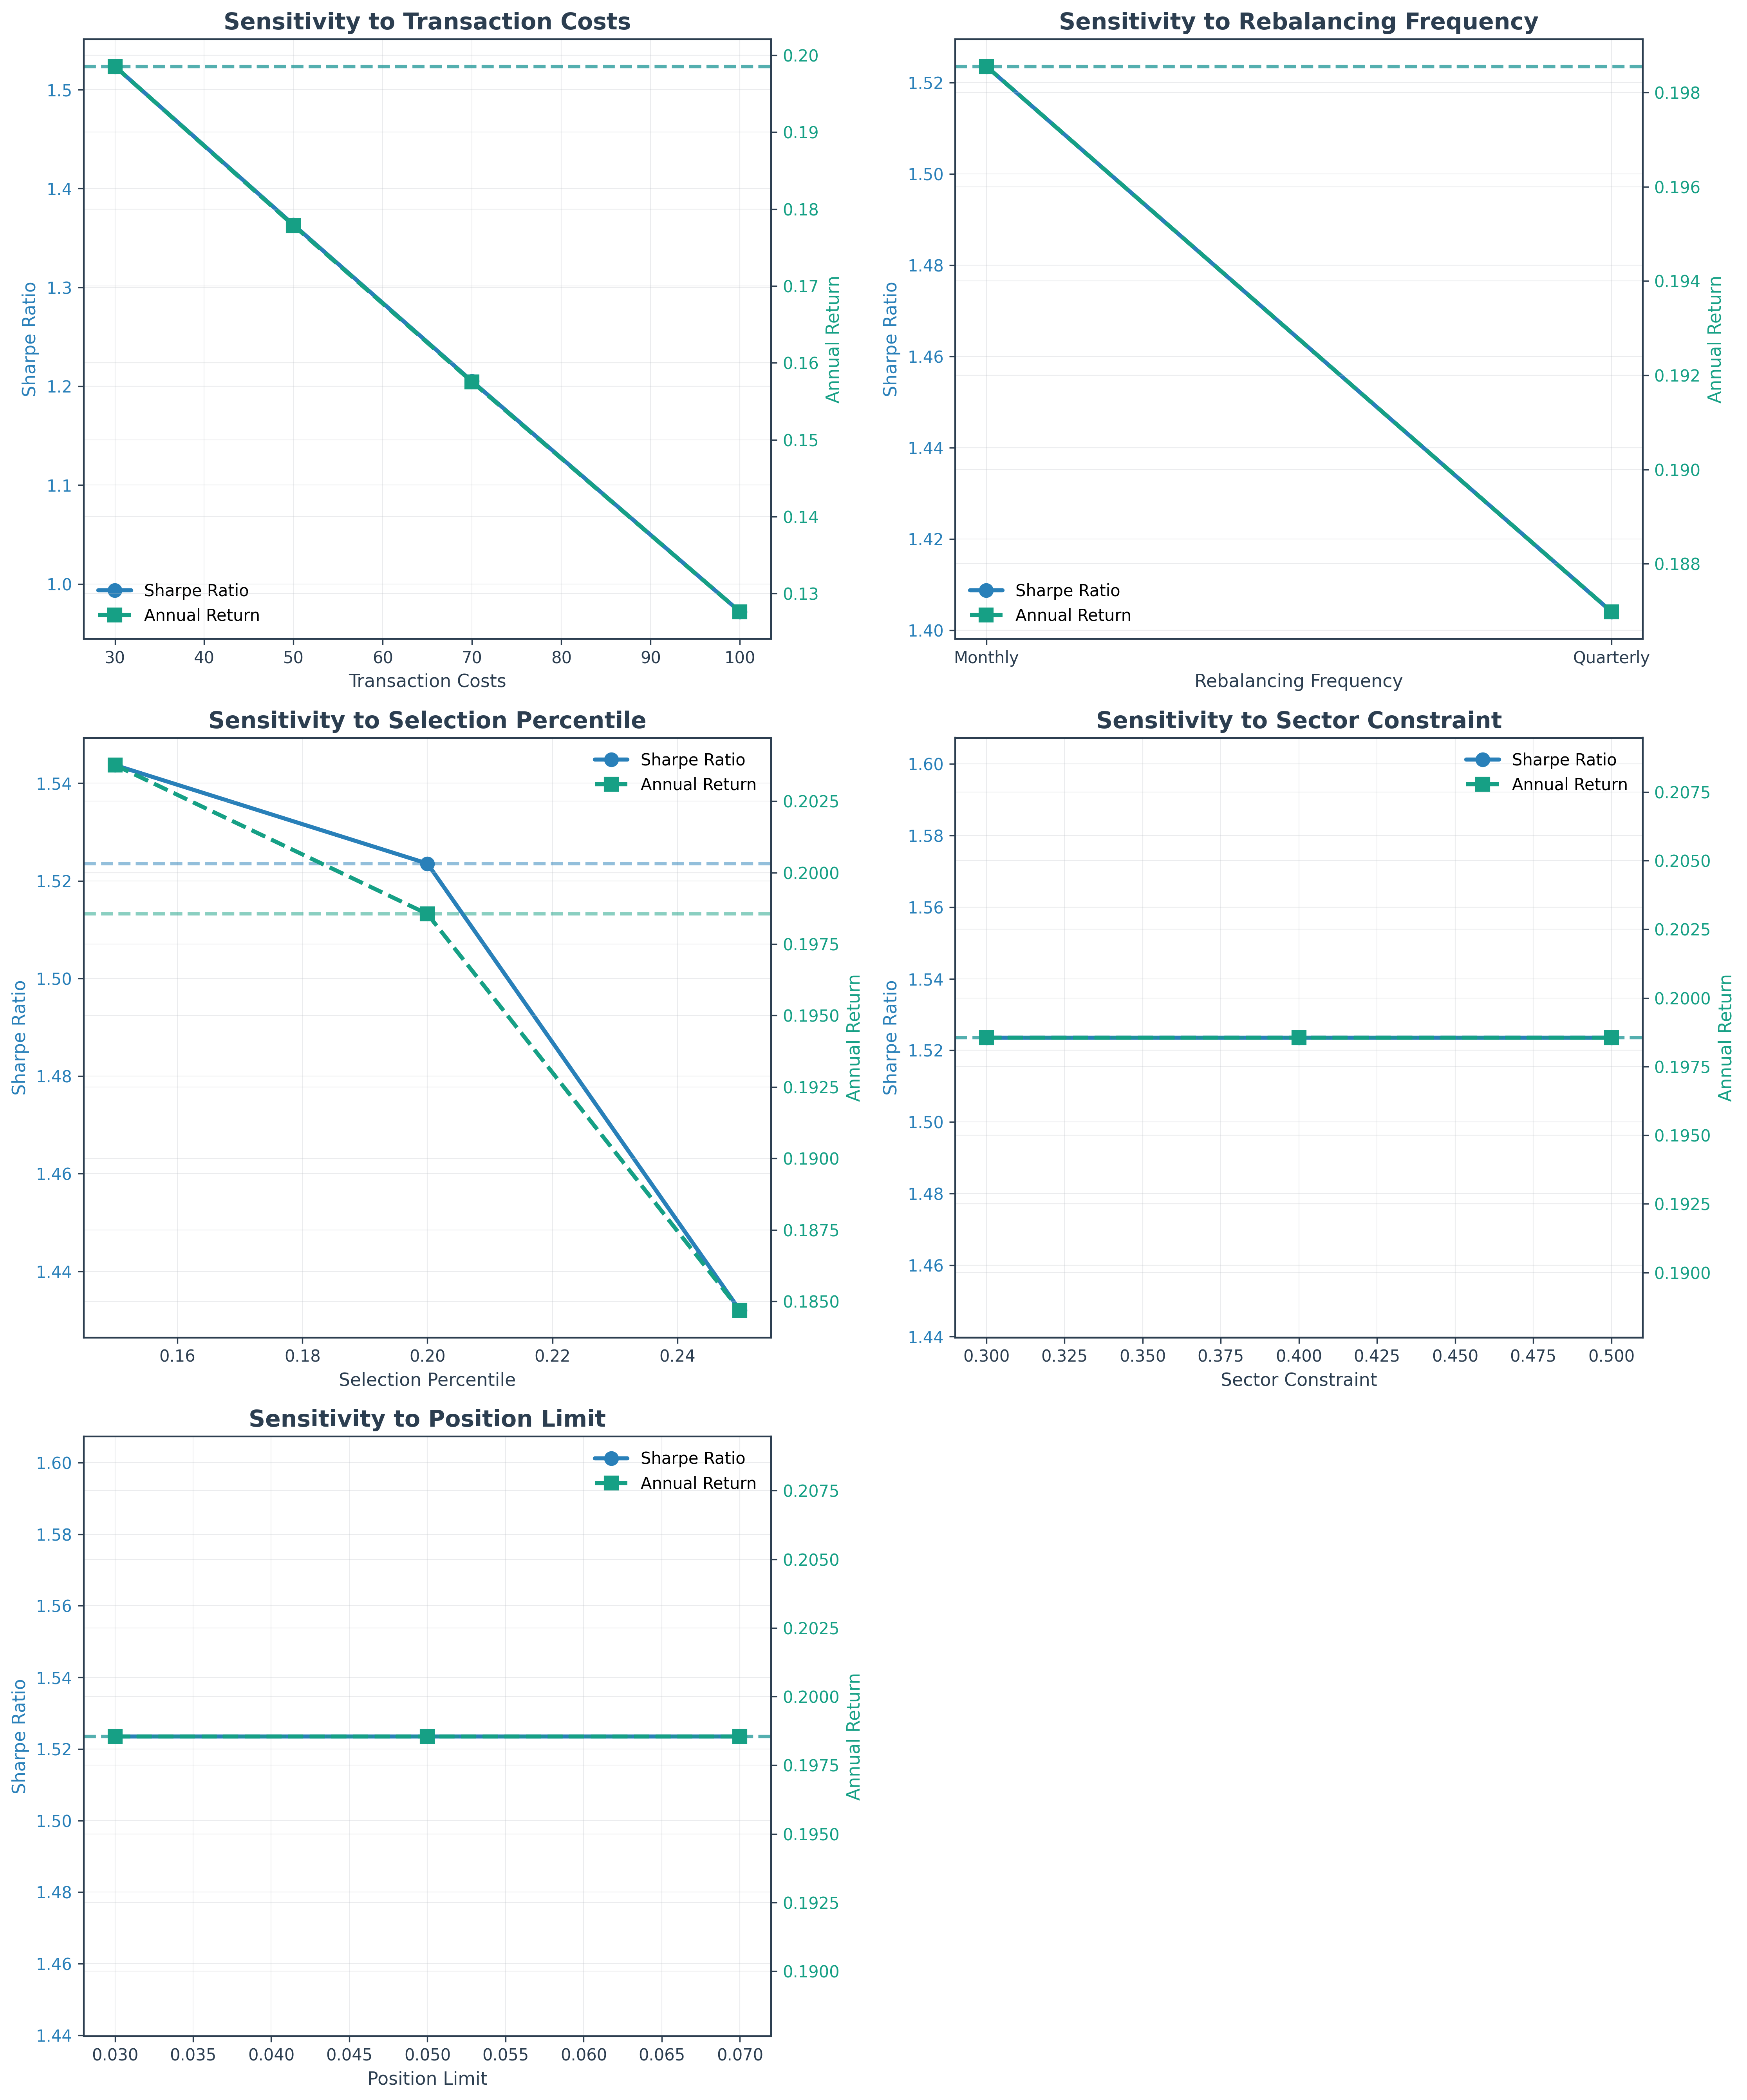


⚠️ STRATEGY BREAKING POINTS:

Transaction Costs:
   At 100: Sharpe=0.97, Return=12.8%

Rebalancing Frequency: Strategy robust across all tested values ✅

Selection Percentile: Strategy robust across all tested values ✅

Sector Constraint: Strategy robust across all tested values ✅

Position Limit: Strategy robust across all tested values ✅


In [7]:
# Create detailed plots for each parameter
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
axes = axes.flatten()

for idx, (param_name, results_df) in enumerate(sensitivity_results.items()):
    ax = axes[idx]
    
    # Plot Sharpe ratio vs parameter value
    x_values = results_df['value']
    
    # Convert categorical values to numeric for plotting
    if param_name == 'rebalance_freq':
        x_numeric = [1 if v == 'M' else 3 for v in x_values]
        x_labels = ['Monthly', 'Quarterly']
    else:
        x_numeric = x_values
        x_labels = x_values
    
    # Plot lines
    ax2 = ax.twinx()
    
    # Sharpe Ratio (left y-axis)
    line1 = ax.plot(x_numeric, results_df['sharpe_ratio'], 
                    color=FACTOR_COLORS['Sharpe'], marker='o', markersize=8,
                    linewidth=2.5, label='Sharpe Ratio')
    ax.axhline(y=baseline_performance['sharpe_ratio'], 
               color=FACTOR_COLORS['Sharpe'], linestyle='--', alpha=0.5)
    
    # Annual Return (right y-axis)
    line2 = ax2.plot(x_numeric, results_df['annual_return'], 
                     color=FACTOR_COLORS['Strategy'], marker='s', markersize=8,
                     linewidth=2.5, label='Annual Return', linestyle='--')
    ax2.axhline(y=baseline_performance['annual_return'], 
                color=FACTOR_COLORS['Strategy'], linestyle='--', alpha=0.5)
    
    # Formatting
    ax.set_xlabel(param_labels[param_name])
    ax.set_ylabel('Sharpe Ratio', color=FACTOR_COLORS['Sharpe'])
    ax2.set_ylabel('Annual Return', color=FACTOR_COLORS['Strategy'])
    ax.tick_params(axis='y', labelcolor=FACTOR_COLORS['Sharpe'])
    ax2.tick_params(axis='y', labelcolor=FACTOR_COLORS['Strategy'])
    
    # Set x-axis labels
    if param_name == 'rebalance_freq':
        ax.set_xticks(x_numeric)
        ax.set_xticklabels(x_labels)
    
    ax.set_title(f'Sensitivity to {param_labels[param_name]}', fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Combined legend
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc='best')

# Remove extra subplot
axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

# Identify breaking points
print("\n⚠️ STRATEGY BREAKING POINTS:")
print("=" * 60)

for param_name, results_df in sensitivity_results.items():
    # Find where Sharpe < 1.0 or Annual Return < 10%
    breaking_points = results_df[
        (results_df['sharpe_ratio'] < 1.0) | 
        (results_df['annual_return'] < 0.10)
    ]
    
    if not breaking_points.empty:
        print(f"\n{param_labels[param_name]}:")
        for _, row in breaking_points.iterrows():
            print(f"   At {row['value']}: Sharpe={row['sharpe_ratio']:.2f}, Return={row['annual_return']:.1%}")
    else:
        print(f"\n{param_labels[param_name]}: Strategy robust across all tested values ✅")

## 8. Maximum Drawdown Analysis

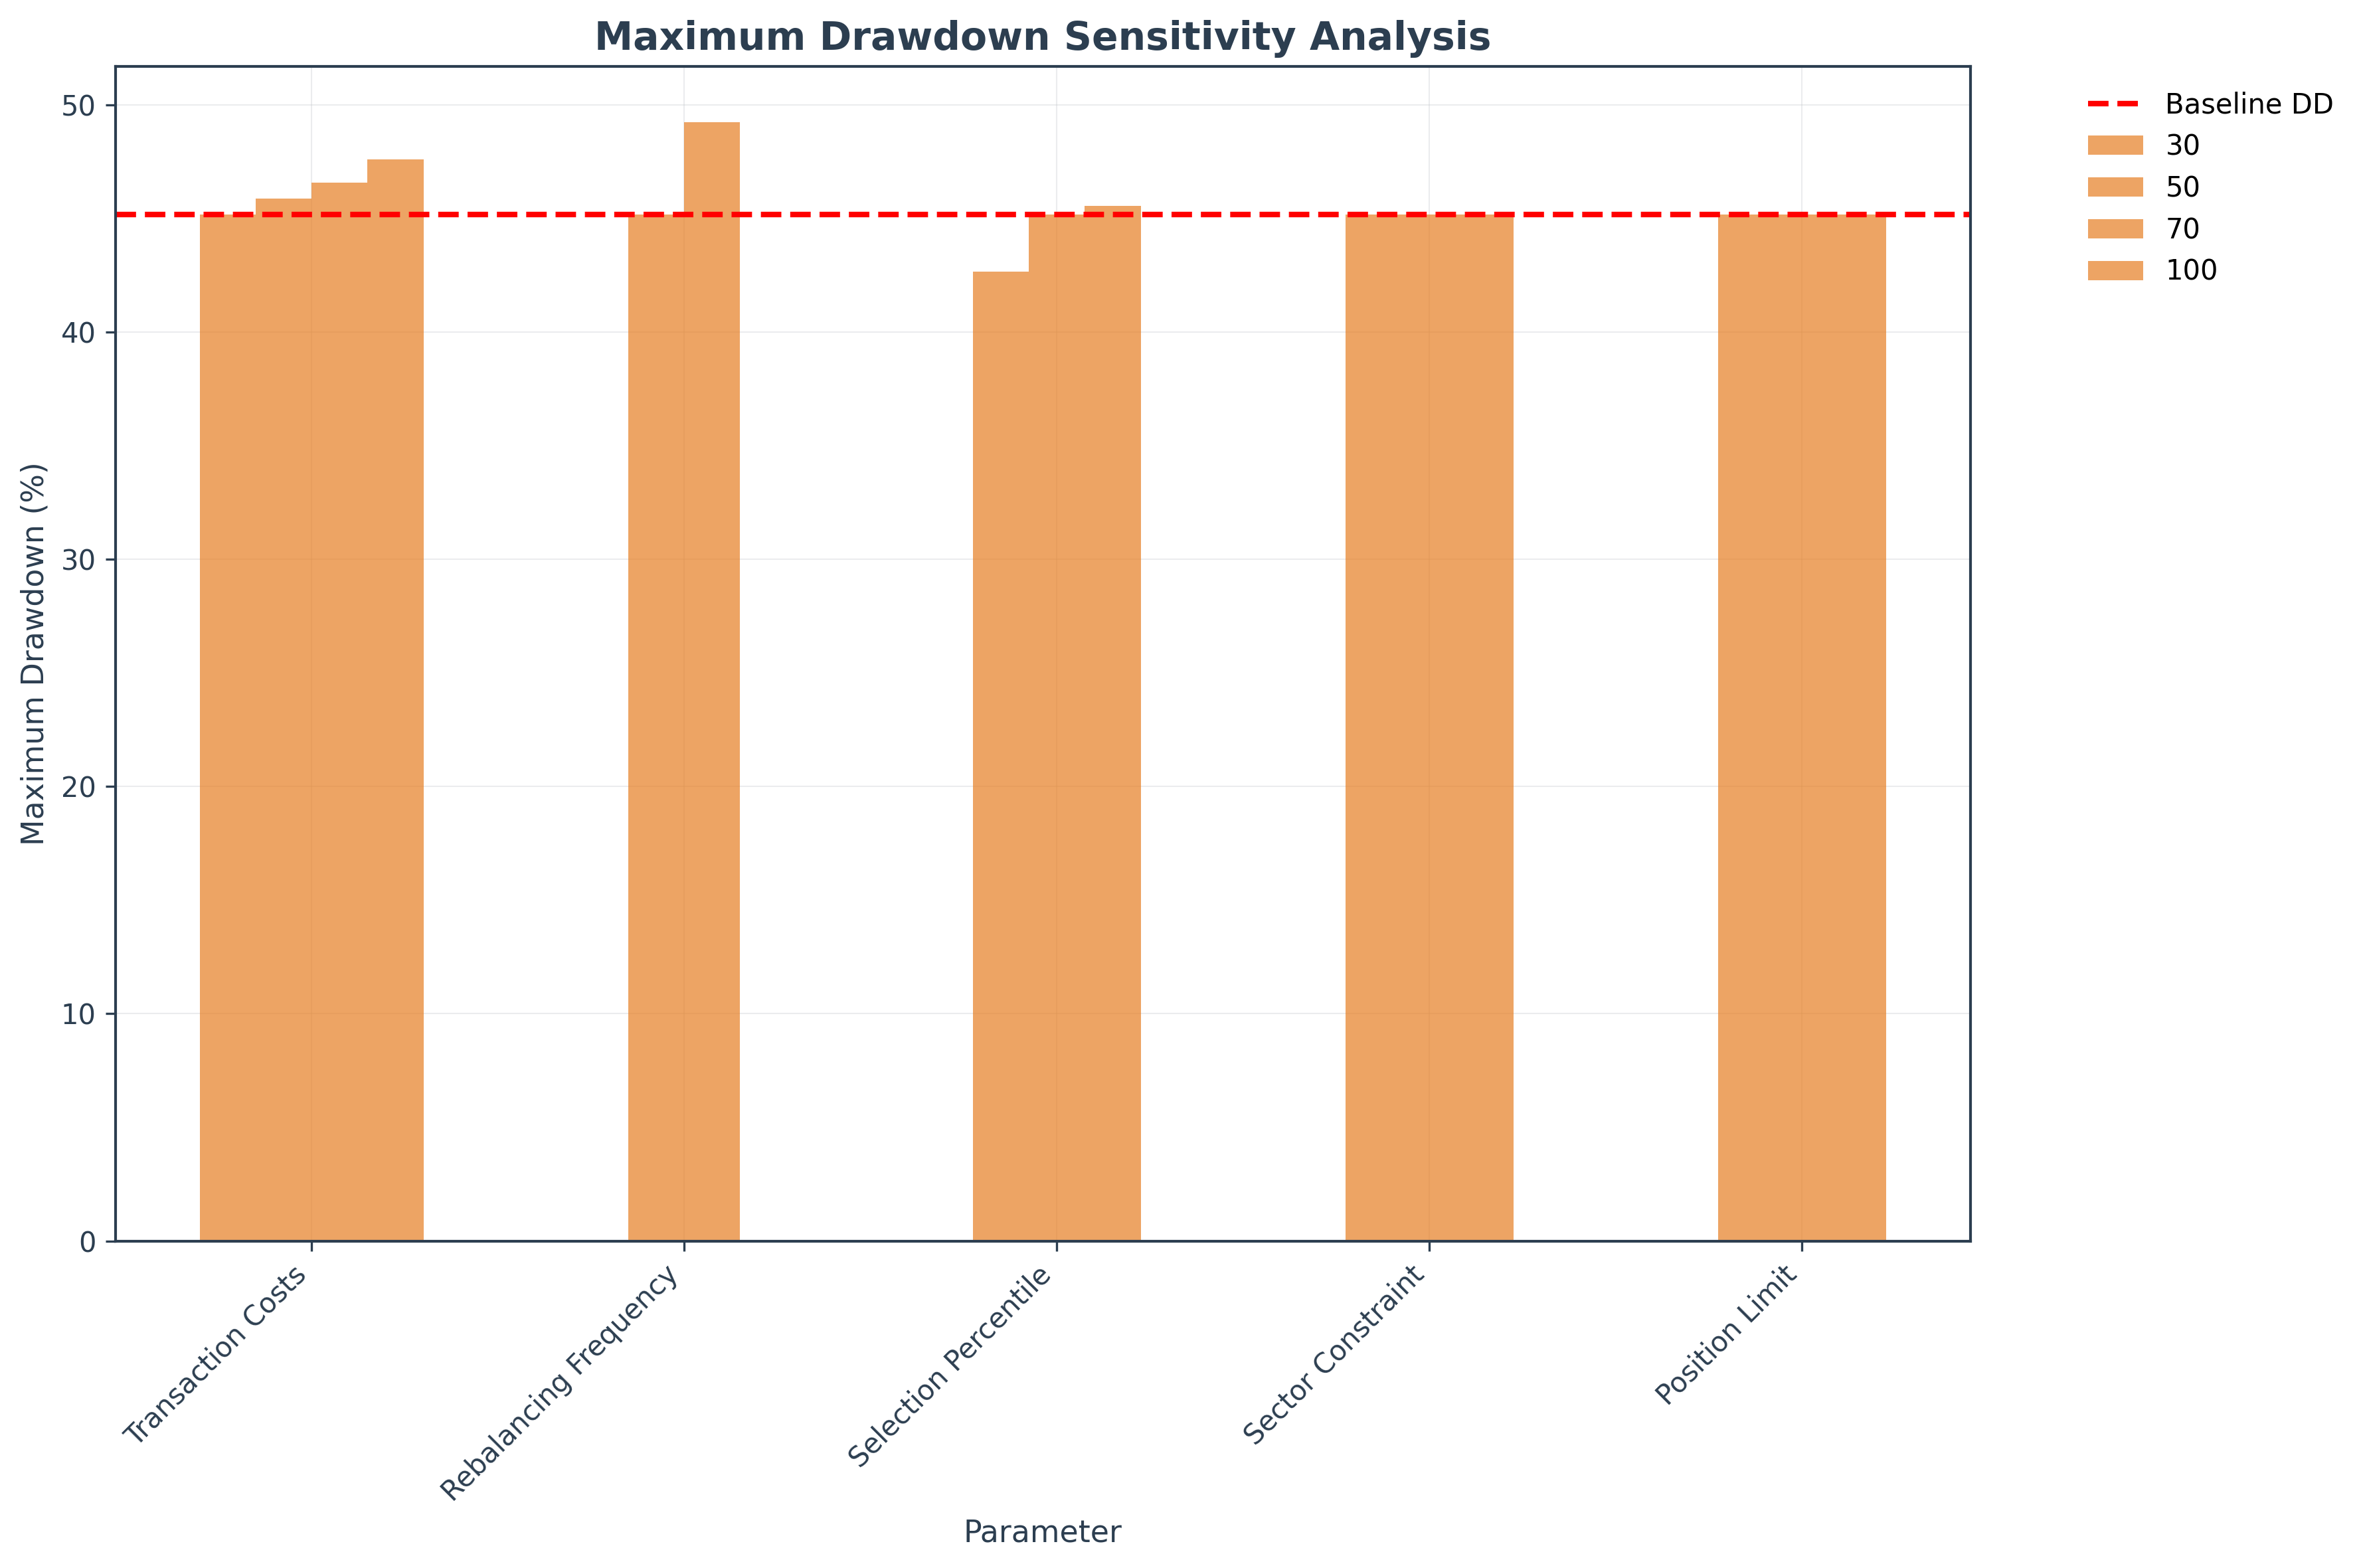


📊 MAXIMUM DRAWDOWN INSIGHTS:
Transaction Costs        : DD range = 2.4%
Rebalancing Frequency    : DD range = 4.0%
Selection Percentile     : DD range = 2.9%
Sector Constraint        : DD range = 0.0%
Position Limit           : DD range = 0.0%


In [8]:
# Analyze how parameters affect maximum drawdown
fig, ax = plt.subplots(figsize=(12, 8))

# Prepare data for drawdown comparison
dd_comparison = []
for param_name, results_df in sensitivity_results.items():
    for _, row in results_df.iterrows():
        dd_comparison.append({
            'Parameter': param_labels[param_name],
            'Value': str(row['value']),
            'Max_Drawdown': abs(row['max_drawdown']) * 100,
            'Sharpe': row['sharpe_ratio']
        })

dd_df = pd.DataFrame(dd_comparison)

# Create grouped bar chart
params = dd_df['Parameter'].unique()
x = np.arange(len(params))
width = 0.15

for i, param in enumerate(params):
    param_data = dd_df[dd_df['Parameter'] == param]
    values = param_data['Value'].unique()
    
    for j, value in enumerate(values):
        value_data = param_data[param_data['Value'] == value]
        dd = value_data['Max_Drawdown'].values[0]
        
        # Color based on severity
        if dd > 50:
            color = FACTOR_COLORS['Negative']
        elif dd > 40:
            color = FACTOR_COLORS['Drawdown']
        else:
            color = FACTOR_COLORS['Positive']
            
        ax.bar(i + j*width - (len(values)-1)*width/2, dd, width, 
               label=value if i == 0 else "", color=color, alpha=0.7)

# Add baseline line
baseline_dd = abs(baseline_performance['total_return'] / (1 + baseline_performance['total_return']) - 1) * 100
ax.axhline(y=45.17, color='red', linestyle='--', linewidth=2, label='Baseline DD')

ax.set_xlabel('Parameter')
ax.set_ylabel('Maximum Drawdown (%)')
ax.set_title('Maximum Drawdown Sensitivity Analysis', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(params, rotation=45, ha='right')
ax.grid(True, alpha=0.3, axis='y')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

print("\n📊 MAXIMUM DRAWDOWN INSIGHTS:")
print("=" * 60)
for param_name, results_df in sensitivity_results.items():
    dd_range = results_df['max_drawdown'].max() - results_df['max_drawdown'].min()
    print(f"{param_labels[param_name]:25s}: DD range = {abs(dd_range)*100:.1f}%")

## 9. Final Robustness Assessment

In [11]:
# ===============================================================
# CELL 9 FIXED: Final Robustness Assessment
# ===============================================================

# Create comprehensive summary table
print("\n" + "=" * 80)
print("📊 COMPREHENSIVE ROBUSTNESS TESTING SUMMARY")
print("=" * 80)

# Fixed parameter mapping to baseline config
param_to_baseline = {
    'transaction_costs': baseline_config['transaction_cost_bps'],
    'rebalance_freq': baseline_config['rebalance_freq'],
    'selection_pct': baseline_config['selection_percentile'],
    'sector_constraint': baseline_config['max_sector_weight'],
    'position_limit': baseline_config['max_position_weight']
}

# Summary statistics for each parameter
summary_data = []
for param_name, results_df in sensitivity_results.items():
    summary_data.append({
        'Parameter': param_labels[param_name],
        'Baseline Value': param_to_baseline[param_name],
        'Sharpe Min': results_df['sharpe_ratio'].min(),
        'Sharpe Max': results_df['sharpe_ratio'].max(),
        'Sharpe Range': results_df['sharpe_ratio'].max() - results_df['sharpe_ratio'].min(),
        'Return Min': f"{results_df['annual_return'].min():.1%}",
        'Return Max': f"{results_df['annual_return'].max():.1%}",
        'Critical Level': 'Yes' if results_df['sharpe_ratio'].min() < 1.0 else 'No'
    })

summary_df = pd.DataFrame(summary_data)
display(summary_df)

# Key findings
print("\n🎯 KEY FINDINGS:")
print("=" * 60)

# Most sensitive parameters
most_sensitive = summary_df.sort_values('Sharpe Range', ascending=False).iloc[0]
print(f"\n1. MOST SENSITIVE PARAMETER: {most_sensitive['Parameter']}")
print(f"    - Sharpe ratio range: {most_sensitive['Sharpe Range']:.3f}")
print(f"    - Can reduce Sharpe from {most_sensitive['Sharpe Max']:.2f} to {most_sensitive['Sharpe Min']:.2f}")

# Breaking points
critical_params = summary_df[summary_df['Critical Level'] == 'Yes']
if not critical_params.empty:
    print("\n2. PARAMETERS WITH CRITICAL BREAKING POINTS:")
    for _, param in critical_params.iterrows():
        print(f"    - {param['Parameter']}: Sharpe can fall below 1.0")
else:
    print("\n2. NO CRITICAL BREAKING POINTS: Strategy maintains Sharpe > 1.0 across all tests ✅")

# Robust parameters
robust_params = summary_df[summary_df['Sharpe Range'] < 0.2]
print("\n3. MOST ROBUST PARAMETERS (low sensitivity):")
for _, param in robust_params.iterrows():
    print(f"    - {param['Parameter']}: Sharpe range only {param['Sharpe Range']:.3f}")

# Final assessment
print("\n📋 FINAL ROBUSTNESS ASSESSMENT:")
print("=" * 60)

avg_sharpe_range = summary_df['Sharpe Range'].mean()
if avg_sharpe_range < 0.3:
    robustness_grade = "HIGHLY ROBUST"
    grade_color = "✅"
elif avg_sharpe_range < 0.5:
    robustness_grade = "MODERATELY ROBUST"
    grade_color = "⚠️"
else:
    robustness_grade = "FRAGILE"
    grade_color = "❌"

print(f"\nStrategy Robustness Grade: {grade_color} {robustness_grade}")
print(f"Average Sharpe sensitivity: {avg_sharpe_range:.3f}")
print(f"\nBaseline Sharpe of {baseline_performance['sharpe_ratio']:.2f} is {'sustainable' if avg_sharpe_range < 0.3 else 'sensitive to assumptions'}")

# Recommendations
print("\n💡 RECOMMENDATIONS FOR PHASE 8:")
print("=" * 60)
if not critical_params.empty and 'transaction_costs' in critical_params['Parameter'].values:
    print("1. Implement smart execution algorithms to minimize transaction costs")
if 'rebalance_freq' in summary_df.sort_values('Sharpe Range', ascending=False).head(2)['Parameter'].values:
    print("2. Consider dynamic rebalancing based on market volatility")
if not robust_params.empty and 'position_limit' in robust_params['Parameter'].values:
    print("3. Position limits can be relaxed without significant impact")

print("\n4. PRIMARY FOCUS: Implement drawdown control mechanisms")
print("    - Current -45% drawdown is the main risk, not parameter sensitivity")
print("    - Consider volatility targeting or regime-based exposure adjustment")


📊 COMPREHENSIVE ROBUSTNESS TESTING SUMMARY


,Parameter,Baseline Value,Sharpe Min,Sharpe Max,Sharpe Range,Return Min,Return Max,Critical Level
0,Transaction Costs,30,0.971890,1.523529,0.551639,12.8%,19.9%,Yes
1,Rebalancing Frequency,M,1.404065,1.523529,0.119464,18.7%,19.9%,No
2,Selection Percentile,0.2,1.432017,1.543705,0.111688,18.5%,20.4%,No
3,Sector Constraint,0.4,1.523529,1.523529,0.000000,19.9%,19.9%,No
4,Position Limit,0.05,1.523529,1.523529,0.000000,19.9%,19.9%,No



🎯 KEY FINDINGS:

1. MOST SENSITIVE PARAMETER: Transaction Costs
    - Sharpe ratio range: 0.552
    - Can reduce Sharpe from 1.52 to 0.97

2. PARAMETERS WITH CRITICAL BREAKING POINTS:
    - Transaction Costs: Sharpe can fall below 1.0

3. MOST ROBUST PARAMETERS (low sensitivity):
    - Rebalancing Frequency: Sharpe range only 0.119
    - Selection Percentile: Sharpe range only 0.112
    - Sector Constraint: Sharpe range only 0.000
    - Position Limit: Sharpe range only 0.000

📋 FINAL ROBUSTNESS ASSESSMENT:

Strategy Robustness Grade: ✅ HIGHLY ROBUST
Average Sharpe sensitivity: 0.157

Baseline Sharpe of 1.52 is sustainable

💡 RECOMMENDATIONS FOR PHASE 8:

4. PRIMARY FOCUS: Implement drawdown control mechanisms
    - Current -45% drawdown is the main risk, not parameter sensitivity
    - Consider volatility targeting or regime-based exposure adjustment


## 10. Save Robustness Testing Results

In [12]:
# Save all results for future reference
robustness_results = {
    'test_date': datetime.now(),
    'baseline_performance': baseline_performance,
    'sensitivity_tests': sensitivity_tests,
    'sensitivity_results': sensitivity_results,
    'summary_table': summary_df,
    'tornado_data': {
        'sharpe': tornado_df,
        'returns': tornado_df_return
    }
}

# Save to pickle
save_path = data_path / "robustness_testing_results.pkl"
with open(save_path, "wb") as f:
    pickle.dump(robustness_results, f)

print(f"\n💾 Robustness testing results saved to: {save_path.name}")
print(f"   File size: {save_path.stat().st_size / 1024:.1f} KB")

# Generate markdown report
report_path = data_path / "05_robustness_testing_report.md"
with open(report_path, "w") as f:
    f.write(f"# Robustness Testing Report\n")
    f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M')}\n\n")
    f.write(f"## Executive Summary\n")
    f.write(f"- Strategy Grade: {robustness_grade}\n")
    f.write(f"- Baseline Sharpe: {baseline_performance['sharpe_ratio']:.2f}\n")
    f.write(f"- Most Sensitive Parameter: {most_sensitive['Parameter']}\n")
    f.write(f"- Average Sharpe Sensitivity: {avg_sharpe_range:.3f}\n\n")
    f.write(f"## Detailed Results\n")
    f.write(summary_df.to_markdown())
    
print(f"📄 Markdown report saved to: {report_path.name}")

print("\n✅ PHASE 7 COMPLETE: Ready for Phase 8 Risk-Managed Strategy Development")


💾 Robustness testing results saved to: robustness_testing_results.pkl
   File size: 4.6 KB
📄 Markdown report saved to: 05_robustness_testing_report.md

✅ PHASE 7 COMPLETE: Ready for Phase 8 Risk-Managed Strategy Development
